In [1]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import itertools
from tqdm import tqdm

import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
from glob import glob
import time, datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
%load_ext tensorboard

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

from helper_functions import plot_compare_history, plot_confusion_matrix, plot_history_curves, plot_random_image
from helper_functions import create_checkpoint_callback, create_early_stopping_callback, create_reduce_lr_callback, create_tensorboard_callback

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5


In [2]:
train_101_100_dir = './Food-Vision-REDO/datasets/food_101/train/'
train_101_50_dir = './Food-Vision-REDO/datasets/food_101/train_50/'
train_101_20_dir = './Food-Vision-REDO/datasets/food_101/train_20/'
train_101_10_dir = './Food-Vision-REDO/datasets/food_101/train_10/'
test_101_dir = './Food-Vision-REDO/datasets/food_101/test/'
food_101_dir = './Food-Vision-REDO/datasets/food_101/'

In [3]:
checkpoint_path = './Food-Vision-REDO/checkpoint/'
tensorboard_path = './Food-Vision-REDO/transfer_learning/'

earlystopping_callback = create_early_stopping_callback(
    metric='val_accuracy',
    patience=3
)

checkpoint_callback = create_checkpoint_callback(
    checkpoint_path=checkpoint_path,
    metric='val_loss',
    save_best=True,
    save_weights=True,
)

lr_callback = create_reduce_lr_callback(
    metric="val_loss",
    factor=0.1,
    patience=2,
    verbose=1,
    min_lr=1e-7
)


In [4]:
IMG_SIZE=(224,224)

train_data_100_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_101_100_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=32
).prefetch(tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_101_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    shuffle=False,
    batch_size=32
).prefetch(tf.data.AUTOTUNE)

Found 75750 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [5]:
class_list_all = glob(os.path.join(test_101_dir, '*',))
class_list_all = [i.split('\\')[-1] for i in class_list_all]
class_list_all;

In [6]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2),
    #tf.keras.layers.Rescaling(1./255), # no need for Effnet
])

In [7]:
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE+(3,), name='input_layer')
#x = data_augmentation(inputs)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
x = tf.keras.layers.Dense(len(class_list_all), name='dense_layer')(x)
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy'])


In [8]:
model_checkpoint_path = checkpoint_path + 'base_model_effnetb4.h5'

In [9]:
model_checkpoint_path

'./Food-Vision-REDO/checkpoint/base_model_effnetb4.h5'

In [10]:
create_checkpoint_callback(
    checkpoint_path=model_checkpoint_path,
    metric='val_loss',
    save_best=True,
    save_weights=True,
)


In [11]:
model_2_history = model_2.fit(
    train_data_100_percent,
    epochs=5,
    steps_per_epoch=len(train_data_100_percent),
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    callbacks=[checkpoint_callback]
)

Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 1.8133 - accuracy: 0.5503
Epoch 00001: val_loss improved from inf to 1.58943, saving model to ./Food-Vision-REDO/checkpoint\
2368/2368 [==============================] - 264s 107ms/step - loss: 1.8133 - accuracy: 0.5503 - val_loss: 1.5894 - val_accuracy: 0.5967
Epoch 2/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.3337 - accuracy: 0.6515
Epoch 00002: val_loss improved from 1.58943 to 1.48206, saving model to ./Food-Vision-REDO/checkpoint\
2368/2368 [==============================] - 251s 106ms/step - loss: 1.3337 - accuracy: 0.6515 - val_loss: 1.4821 - val_accuracy: 0.6258
Epoch 3/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.1868 - accuracy: 0.6868
Epoch 00003: val_loss improved from 1.48206 to 1.45364, saving model to ./Food-Vision-REDO/checkpoint\
2368/2368 [==============================] - 251s 106ms/step - loss: 1.1868 - accuracy: 0.6868 - val_loss: 1.4536 - val_accuracy: 

In [12]:
model_2.evaluate(test_data)

790/790 [==============================] - 80s 101ms/step - loss: 1.3749 - accuracy: 0.6480


[1.3748629093170166, 0.6480395793914795]

In [13]:
model_2.save('./Food-Vision-REDO/models/efficientneb4_base_model.h5')
model_2.save_weights('./Food-Vision-REDO/weights/efficientneb4_base_model.h5')

C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [17]:
loaded_model = tf.keras.models.load_model('./Food-Vision-REDO/models/efficientneb4_base_model.h5')
loaded_model.load_weights('./Food-Vision-REDO/weights/efficientneb4_base_model.h5')

In [18]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 114s 140ms/step - loss: 2.1155 - accuracy: 0.4949


[2.1154892444610596, 0.4948514997959137]

In [29]:
for layer in model_2.layers:
    layer.trainable = True

    
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(0.0001),
                     metrics=["accuracy"])

In [25]:
checkpoint_path = './Food-Vision-REDO/checkpoint/'

In [26]:
checkpoint_tune_path = checkpoint_path + 'fine_tune_checkpoints/efficientneb4_fine_tune_augmented.h5'
#checkpoint_callback = create_checkpoint_callback(checkpoint_path=checkpoint_path,metric='val_loss',save_best=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_tune_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
                                                        )

In [27]:
checkpoint_tune_path

'./Food-Vision-REDO/checkpoint/fine_tune_checkpoints/efficientneb4_fine_tune_augmented.h5'

In [30]:
history_efficientnetb4_101_fine_tuning = model_2.fit(train_data_100_percent,
                                                        epochs=50, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data_100_percent),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[
                                                            lr_callback,
                                                            earlystopping_callback,
                                                            checkpoint_callback, 
                                                            create_tensorboard_callback(
                                                                dir_name=tensorboard_path,
                                                                experiment_name='efficientnetb4_101_fine_tuning')])

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning//logs/fits/efficientnetb4_101_fine_tuning/20211118-194953
Epoch 1/50
2368/2368 [==============================] - 887s 363ms/step - loss: 0.8301 - accuracy: 0.7716 - val_loss: 0.9923 - val_accuracy: 0.7338 - lr: 1.0000e-04
Epoch 2/50
2368/2368 [==============================] - 865s 365ms/step - loss: 0.2978 - accuracy: 0.9156 - val_loss: 1.1750 - val_accuracy: 0.7259 - lr: 1.0000e-04
Epoch 3/50
2368/2368 [==============================] - ETA: 0s - loss: 0.1161 - accuracy: 0.9641
Epoch 00003: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
2368/2368 [==============================] - 861s 364ms/step - loss: 0.1161 - accuracy: 0.9641 - val_loss: 1.3644 - val_accuracy: 0.7323 - lr: 1.0000e-04
Epoch 4/50
2368/2368 [==============================] - 879s 371ms/step - loss: 0.0332 - accuracy: 0.9905 - val_loss: 1.3182 - val_accuracy: 0.7635 - lr: 1.0000e-05
Epoch 5/50
2368/2368 [=========================

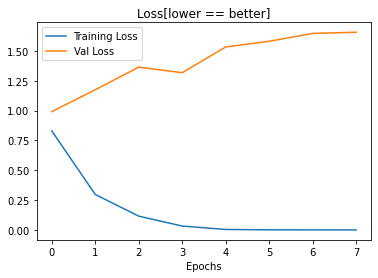

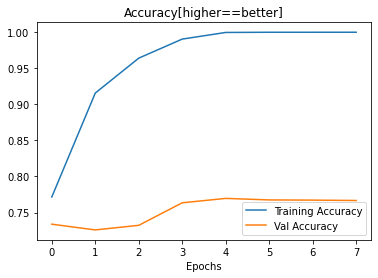

In [31]:
plot_history_curves(history_efficientnetb4_101_fine_tuning)

In [32]:
model_2.evaluate(test_data)

790/790 [==============================] - 81s 102ms/step - loss: 1.5326 - accuracy: 0.7802


[1.5325756072998047, 0.7801584005355835]

In [ ]:
model_2.save('efficientnetb4_best_model')

INFO:tensorflow:Assets written to: efficientnetb4_best_model\assets
